Importing libraries and packages 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from windrose import WindroseAxes

Dataset uploading and statistics for missing values 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from windrose import WindroseAxes  # pip install windrose

# Set plot style
sns.set(style='whitegrid')

# Load data
file_path = 'C:/Users/mukit/Desktop/week 0/solar-challenge-week/data/togo-dapaong_qc.csv'
df = pd.read_csv(file_path, parse_dates=['Timestamp'])

print("Original data shape:", df.shape)


Original data shape: (525600, 19)


 STEP 1: Summary Statistics & Missing-Value Report

In [4]:
# Summary statistics for numeric columns
print("===== Summary Statistics =====")
print(df.describe(include=[np.number]))

# Missing value report
missing = df.isna().sum()
print("\n===== Missing Value Report =====")
print(missing[missing > 0])

# Columns with more than 5% missing
threshold = 0.05 * len(df)
print("\n===== Columns with >5% Missing =====")
print(missing[missing > threshold])


===== Summary Statistics =====
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000      14.900000       3.300000       0.000000   
25

STEP 2: Outlier Detection & Basic Cleaning

In [5]:
df_clean = df.copy()

# Impute missing values in key numeric columns
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
for col in key_cols:
    if df_clean[col].isna().sum() > 0:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Compute Z-scores and flag outliers
for col in key_cols:
    df_clean[f'{col}_Z'] = np.abs(stats.zscore(df_clean[col], nan_policy='omit'))
    df_clean[f'{col}_Outlier'] = df_clean[f'{col}_Z'] > 3

# Export cleaned data (assuming folder `data/` exists and is in .gitignore)
df_clean.to_csv('C:/Users/mukit/Desktop/week 0/solar-challenge-week/data/togo_clean.csv', index=False)
print("\nCleaned data exported to data/togo_clean.csv")



Cleaned data exported to data/togo_clean.csv


STEP 3: Time Series Analysis

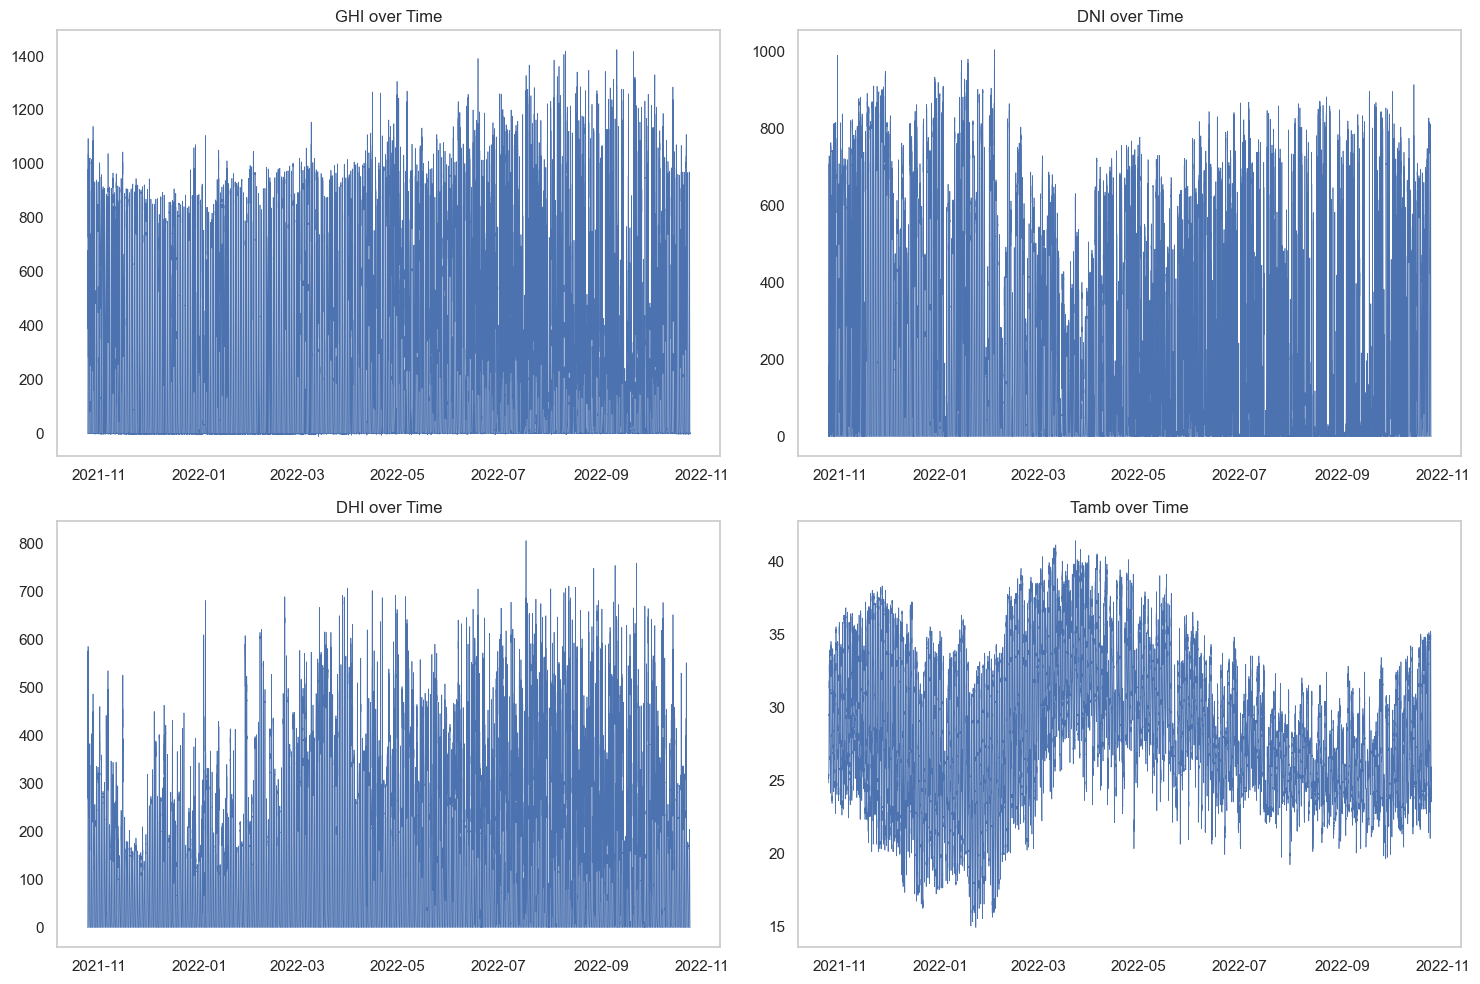

In [16]:
plt.figure(figsize=(15, 10))
ts_cols = ['GHI', 'DNI', 'DHI', 'Tamb']

for i, col in enumerate(ts_cols, 1):
    plt.subplot(2, 2, i)
    plt.plot(df_clean['Timestamp'], df_clean[col], linewidth=0.5)
    plt.title(f'{col} over Time')
    plt.grid()

plt.tight_layout()
plt.show()


STEP 4: Cleaning Impact on ModA & ModB

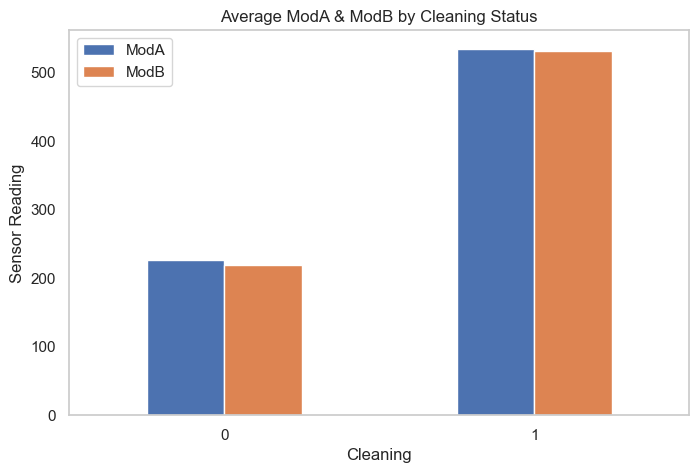

In [17]:
if 'Cleaning' in df_clean.columns:
    df_grouped = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().reset_index()
    df_grouped.plot(x='Cleaning', kind='bar', figsize=(8, 5))
    plt.title('Average ModA & ModB by Cleaning Status')
    plt.ylabel('Sensor Reading')
    plt.xticks(rotation=0)
    plt.grid()
    plt.show()


STEP 5: Correlation & Relationship Analysis

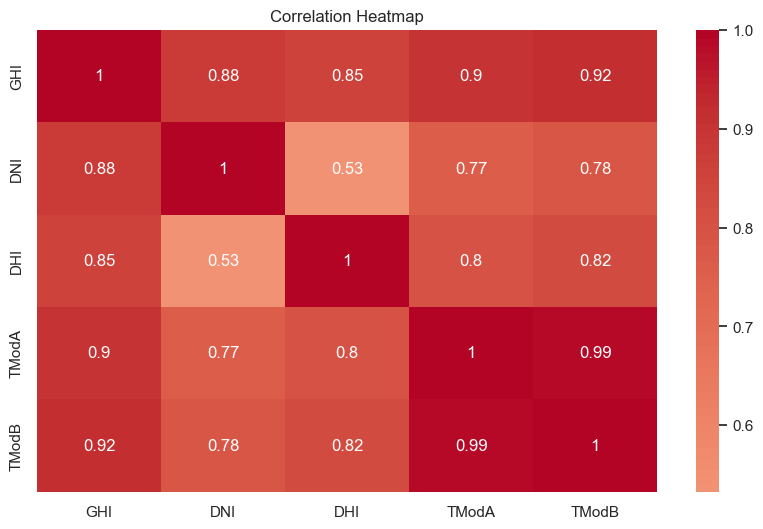

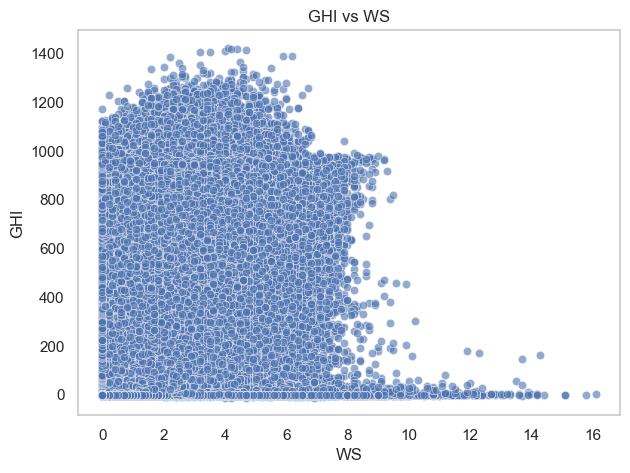

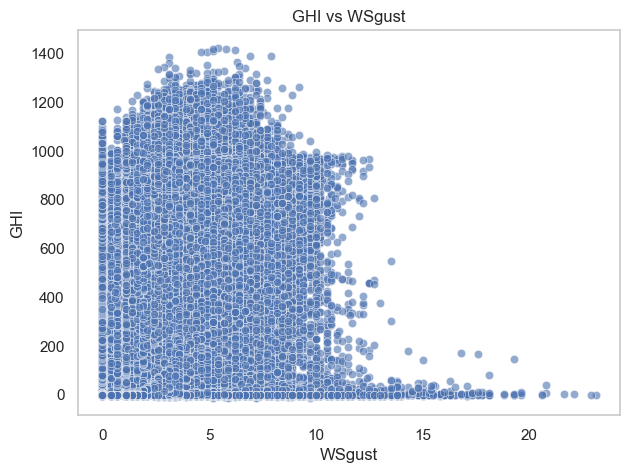

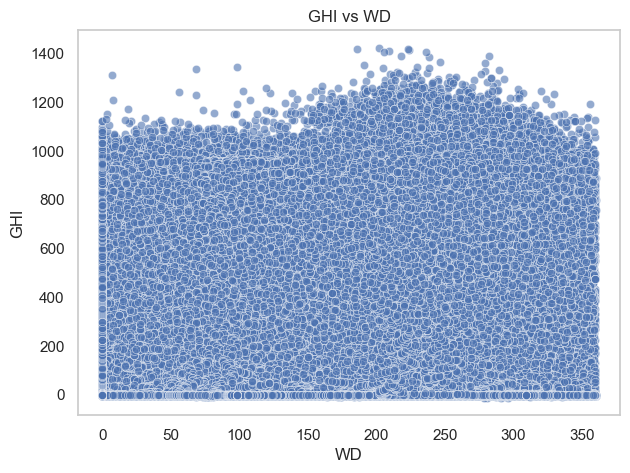

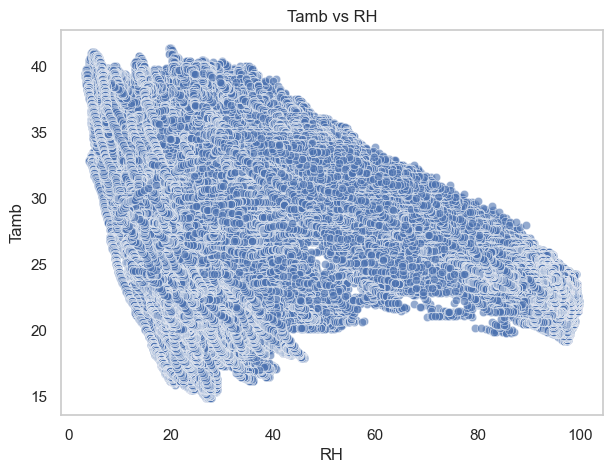

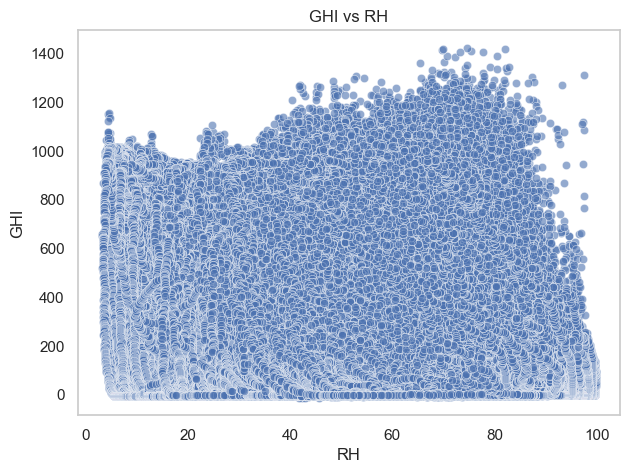

In [18]:
# Correlation heatmap
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

# Scatter plots
scatter_pairs = [
    ('WS', 'GHI'),
    ('WSgust', 'GHI'),
    ('WD', 'GHI'),
    ('RH', 'Tamb'),
    ('RH', 'GHI')
]

for x, y in scatter_pairs:
    if x in df_clean.columns and y in df_clean.columns:
        plt.figure(figsize=(7, 5))
        sns.scatterplot(data=df_clean, x=x, y=y, alpha=0.6)
        plt.title(f'{y} vs {x}')
        plt.grid()
        plt.show()


STEP 6: Wind & Distribution Analysis

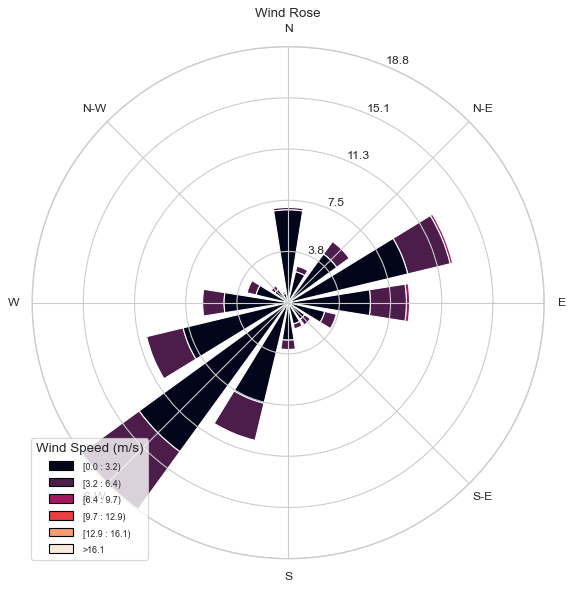

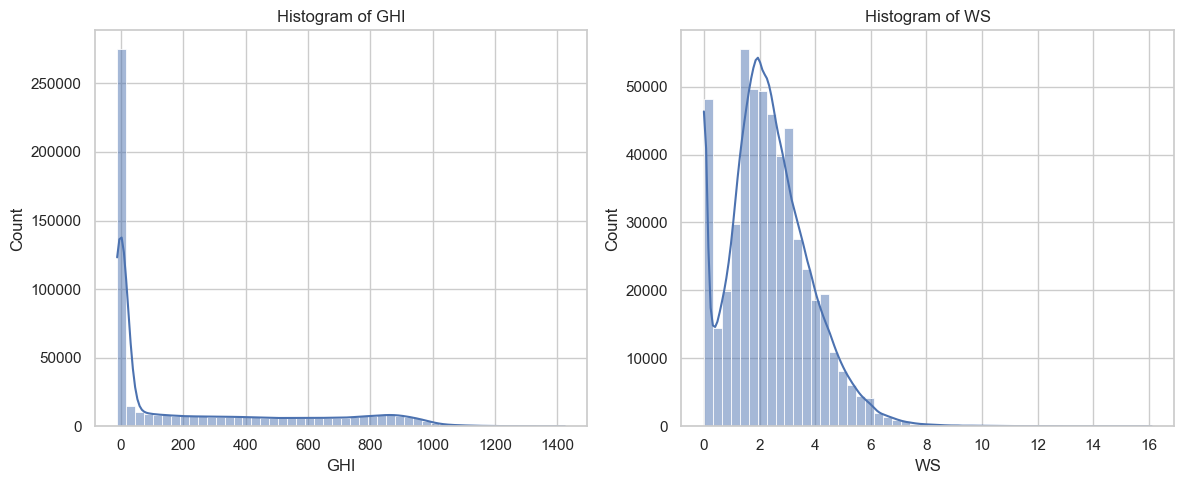

In [19]:
# Wind rose plot
if 'WD' in df_clean.columns and 'WS' in df_clean.columns:
    ax = WindroseAxes.from_ax()
    ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
    ax.set_legend(title='Wind Speed (m/s)')
    plt.title('Wind Rose')
    plt.show()

# Histograms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['GHI'], bins=50, kde=True)
plt.title('Histogram of GHI')

if 'WS' in df_clean.columns:
    plt.subplot(1, 2, 2)
    sns.histplot(df_clean['WS'], bins=50, kde=True)
    plt.title('Histogram of WS')

plt.tight_layout()
plt.show()


STEP 7: Temperature Analysis

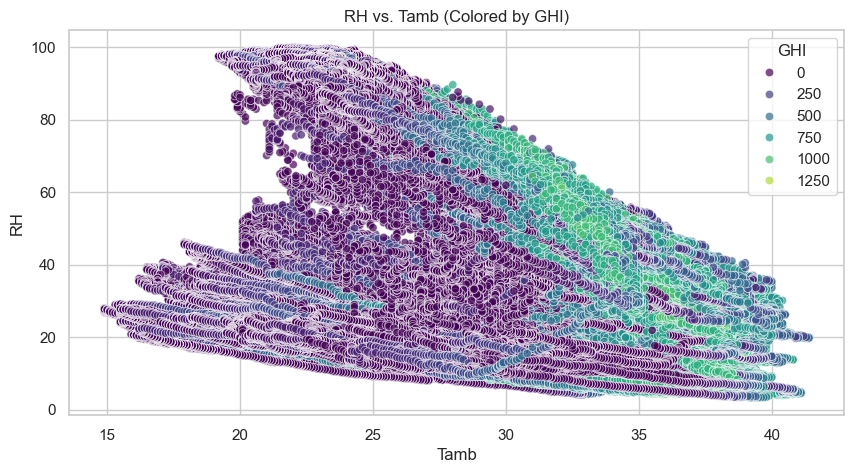

In [20]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_clean, x='Tamb', y='RH', hue='GHI', palette='viridis', alpha=0.7)
plt.title('RH vs. Tamb (Colored by GHI)')
plt.show()


 STEP 8: Bubble Chart (GHI vs Tamb)

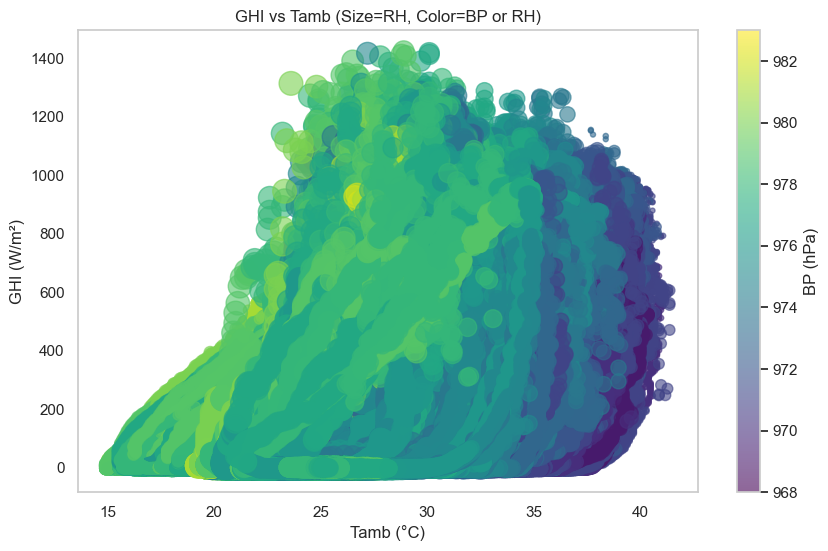

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(
    x=df_clean['Tamb'],
    y=df_clean['GHI'],
    s=df_clean['RH'] * 3,
    c=df_clean['BP'] if 'BP' in df_clean.columns else df_clean['RH'],  # Fallback if BP not present
    alpha=0.6,
    cmap='viridis'
)
plt.colorbar(label='BP (hPa)' if 'BP' in df_clean.columns else 'RH (%)')
plt.xlabel('Tamb (°C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs Tamb (Size=RH, Color=BP or RH)')
plt.grid()
plt.show()
